In [1]:
"""
Goal:
To calculate income after taxes in each province/state in Canada and the U.S.A. for 2021. 

Data were obtained from: 
https://www.canada.ca/en/revenue-agency/services/tax/individuals/frequently-asked-questions-individuals/canadian-income-tax-rates-individuals-current-previous-years.html 
and
https://taxfoundation.org/publications/state-individual-income-tax-rates-and-brackets/

Caveats/Assumptions:
- For the purpose of this exercise, it is assumed that purchasing power is locally equivalent 
(e.g. a loaf of bread costs $5 CAD in Canada and $5 USD in America.). 
No attempt has been made to convert one currency to another for comparison's sake.

- "Standard deductions", tax credits and incentives are not taken into account when calculating post-tax income.

- Other 'Cost of living' factors such as health insurance, which is largely part of Canadian federal/provincial taxes and falls on the individual in the U.S.,
are not taken into account when calculating post-tax income.

"""

'\nGoal:\nTo calculate income after taxes in each province/state in Canada and the U.S.A. for 2021. \n\nData were obtained from: \nhttps://www.canada.ca/en/revenue-agency/services/tax/individuals/frequently-asked-questions-individuals/canadian-income-tax-rates-individuals-current-previous-years.html \nand\nhttps://taxfoundation.org/publications/state-individual-income-tax-rates-and-brackets/\n\nCaveats/Assumptions:\n- For the purpose of this exercise, it is assumed that purchasing power is locally equivalent \n(e.g. a loaf of bread costs $5 CAD in Canada and $5 USD in America.). \nNo attempt has been made to convert one currency to another for comparison\'s sake.\n\n- "Standard deductions", tax credits and incentives are not taken into account when calculating post-tax income.\n\n- Other \'Cost of living\' factors such as health insurance, which is largely part of Canadian federal/provincial taxes and falls on the individual in the U.S.,\nare not taken into account when calculating pos

In [2]:
import pandas as pd

In [3]:
"""Step 1: import data and clean"""
"""Import and format Canadian tax rates"""
# PRECONDITIONS:
# the file is a csv (prepared in Excel or similar)
# column headers are "Province" and "Statement"
# the string in the "Statement" column has the format "(rate)% on the next $(CAD dollar amount), +"

# read in a file of provinces (column 1) and a string describing the tax rates for different brackets
filepath = "C:/Users/STW/Documents/Python Projects/Marginal taxes calculations/Canada tax rates.csv"
CANdf = pd.read_csv(filepath)

# make a new dataframe to capture the info
formatted_CANdf = pd.DataFrame()

# add a country identifier column
formatted_CANdf['Country'] = ['Canada' for item in range(len(CANdf))]

# make ordered lists of tax rates and tax brackets (amount of money required in each bin)
rates = []
bound = []

# go through the Statement string, extract and record the tax rate (%) and the bound for the bracket
for line in range(len(CANdf)):
    statement = CANdf['Statement'][line]
    rates.append(statement[0:statement.index('%')])
    if 'first' in statement:
        bound.append(0)
    elif 'over' in statement:
        bound.append(float((statement[statement.index('$')+1:statement.index('$')+10].replace(',','').replace(' ','').replace('o','').replace('+','').replace('f',''))))
    else:
        bound.append(float((statement[statement.index('$')+1:statement.index('$')+10].replace(',','').replace(' ','').replace('o','').replace('+','').replace('f','')))+bound[-1])

# add these lists to the data frame
formatted_CANdf['Province/State'] = CANdf['Province'][:]
formatted_CANdf['Bound'] = bound
formatted_CANdf['Rate'] = rates
formatted_CANdf['Rate'] = formatted_CANdf['Rate'].astype(float)

"""Import and format American tax rates"""
# PRECONDITIONS:
# the file is a csv (prepared in Excel or similar)
# column headers are "State", rate (tax rate % in a bracket), and bound (amount of money required to move up into the next bracket)
# the string in the 'Bound' column is in USD

### !NOTE!: Later in the program I found that the spreadsheet obtained from taxfoundation.org (above) did not have
### a 'base case' for certain states (ie. 'Delaware' did not have a $0 'Bound'). I corrected this in the spreadsheet 
### instead of compensating for it in my code. 

# read in a file of provinces (column 1) and a string describing the tax rates for different brackets
filepath = "C:/Users/STW/Documents/Python Projects/Marginal taxes calculations/USA tax rates.csv"
USAdf = pd.read_csv(filepath)

# make a new data frame to capture the info
formatted_USAdf = pd.DataFrame()

# add a country identifier column
formatted_USAdf['Country'] = ['USA' for item in range(len(USAdf))]

# re- format the 'Rate' and 'Bound' columns to be numbers
formatted_USAdf['Province/State'] = USAdf['State']
formatted_USAdf['Bound'] = USAdf['Bound'].str.replace('$','').str.replace(',','').astype(float)
formatted_USAdf['Rate'] = USAdf['Rate'].str.replace('none','0').str.replace('%','').astype(float)

# combine the Canadian and American tax rates dataframes
df = formatted_CANdf.append(formatted_USAdf)

<ipython-input-3-9c46699e193b>:61: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  formatted_USAdf['Bound'] = USAdf['Bound'].str.replace('$','').str.replace(',','').astype(float)


In [4]:
"""Step 2: Design functions to calculate marginal tax rates"""
def state_tax(income, place, df):
    """
    Inputs: 
    - income (a float)
    - place (a string: a Canadian Province or an American State)
    - df (source dataframe containing marginal tax rates and bracket bounds for each place above)
    
    Output:
    - a float: amount of state/provincial tax paid in the given province/state, using year 2021 marginal tax rates.
    """
    # define the sub-frame of interest
    state_df = df.loc[df['Province/State'] == place]
    # define the amount of money you're starting with
    unpaid = income
    # define how much has been paid so far
    tax_paid = 0
    # loop while there's still money you haven't paid tax on
    while unpaid > 0:
        # define the payment bracket you'll be paying in
        bracket = state_df.loc[state_df['Bound']<unpaid].Bound.iloc[-1]
        # find the tax rate at that bracket and convert it to a percentage
        bracket_rate = state_df.loc[state_df['Bound']<unpaid].Rate.iloc[-1] / 100
        # pay the tax on money in that bracket
        tax_paid += (unpaid - bracket) * bracket_rate
        # update the "unpaid" amount to reflect the money you have paid tax on
        unpaid = bracket - .01

    return round(tax_paid,2)

def fed_tax(income, place, df):
    """
    Inputs: 
    - income (a float)
    - place (a string: a Canadian Province or an American State)
    - df (source dataframe containing marginal tax rates and bracket bounds for each place above)
    
    Output:
    - a float: amount of federal tax paid in the given province/state, using year 2021 marginal tax rates.
    """
    
    # define the sub-frame of interest
    state_df = df.loc[df['Province/State'] == place]
    # for the given state/province (place), go to the corresponding country's federal tax entry
    country_df = df.loc[df['Province/State'] == state_df['Country'].iloc[0]]
    # define the amount of money you're starting with
    unpaid = income
    # define how much has been paid so far
    tax_paid = 0
    while unpaid > 0:
        # define the payment bracket you'll be paying in
        bracket = country_df.loc[country_df['Bound']<unpaid].Bound.iloc[-1]
        # find the tax rate at that bracket and convert it to a percentage
        bracket_rate = country_df.loc[country_df['Bound']<unpaid].Rate.iloc[-1] / 100
        # pay the tax on money in that bracket
        tax_paid += (unpaid - bracket) * bracket_rate
        # update the "unpaid" amount to reflect the money you have paid tax on
        unpaid = bracket - .01
    # Quebec has a special agreement with the federal gov't where they pay less federal tax and pay more provincial
    if place == 'Quebec': 
        return round(tax_paid - (tax_paid*.165),2)
    else:
        return round(tax_paid,2)   

In [5]:
"""Step 3: calculate taxes on income $1-$1,000,000"""
# columns we want for our data:
places = []
gross_incomes = []
net_incomes = []
bad_places = []

# loop through each separate region
for place in df['Province/State'].unique():
    try:
        if place in ['USA', 'USA Filing Jointly', 'Canada']:
            continue
        else:
            # step through possible incomes in $10,000 chunks (to save time)
            for income in range(0,1000000,10000):
                # store the place, the 'income' input and the 'income after taxes' output
                places.append(place)
                gross_incomes.append(float(income))
                net_incomes.append(round(income - fed_tax(income,place,df) - state_tax(income,place,df),2))
    # this catches cases where the base bound (0$, 0% tax rate) is not present for any 'place' in the dataset
    except:
         bad_places.append(place)

# make a dataframe containing these data
tax_df = pd.DataFrame()
tax_df['Place'] = places
tax_df['Income before tax'] = gross_incomes
tax_df['Income after tax'] = net_incomes

# save the dataframe
# tax_df.to_csv('C:/Users/STW/Documents/Python Projects/Marginal taxes calculations/USA_CAN_tax_table.csv', index = False)      

In [6]:
"""Play around"""
tax_df[tax_df['Place'] == 'Quebec'].loc[tax_df['Income before tax']==180000]

,Place,Income before tax,Income after tax
18,Quebec,180000.0,107999.79


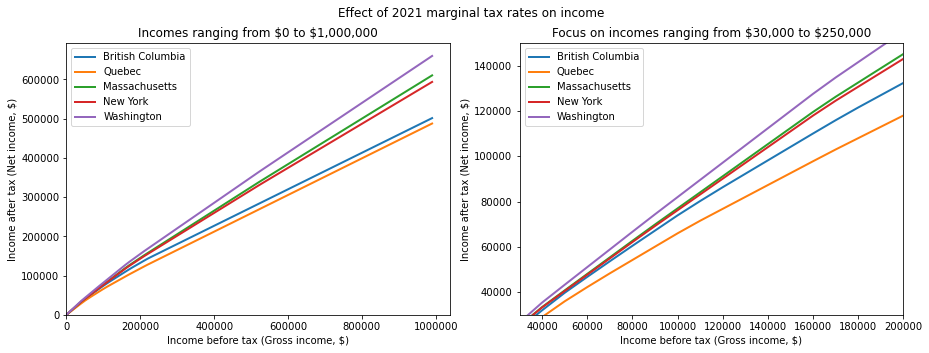

In [7]:
"""Step 4: Graph stuff"""
import seaborn as sns
import matplotlib.pyplot as plt

# Looking at particular places of interest
places = ['British Columbia', 'Quebec', 'Massachusetts','New York', 'Washington']

# make two subplots to allow seeing the full picture and a more narrow range of incomes
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
fig.suptitle('Effect of 2021 marginal tax rates on income')

# generate the plots for each place
for place in places:
    sns.lineplot(ax = axes[0], x = 'Income before tax', y = 'Income after tax', data = tax_df.loc[tax_df['Place'] == place], 
                 label = place, linewidth = 2)
    sns.lineplot(ax = axes[1], x = 'Income before tax', y = 'Income after tax', data = tax_df.loc[tax_df['Place'] == place], 
                 label = place, linewidth = 2)

# set the spacing between the plots
plt.subplots_adjust(wspace = .18)

# tweak the plots so they show different things and are pretty
axes[0].set_title('Incomes ranging from \$0 to \$1,000,000')
axes[0].set_xlabel('Income before tax (Gross income, $)')
axes[0].set_ylabel('Income after tax (Net income, $)')
axes[0].set_xlim(0.0)
axes[0].set_ylim(0.0)
axes[0].ticklabel_format(style='plain', axis='y')
axes[0].ticklabel_format(style='plain', axis='x')

axes[1].set_title('Focus on incomes ranging from \$30,000 to \$250,000')
axes[1].set_xlabel('Income before tax (Gross income, $)')
axes[1].set_ylabel('Income after tax (Net income, $)')
axes[1].legend(loc = 'upper left')
axes[1].set_xlim(30000.0,200000.0)
axes[1].set_ylim(30000.0,150000.0)
axes[1].ticklabel_format(style='plain', axis='y')
axes[1].ticklabel_format(style='plain', axis='x');

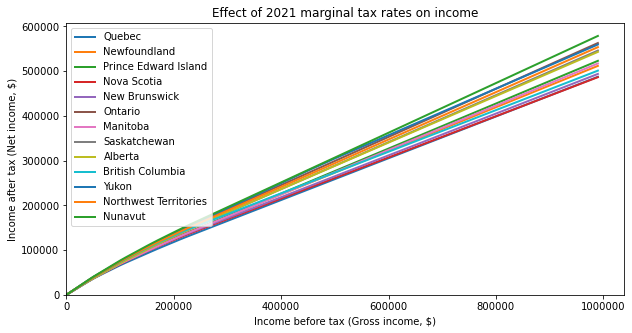

In [8]:
#graphing all Canadian provinces for comparison
places = tax_df['Place'].unique()[:13].tolist()
plt.figure(figsize = (10,5))
for place in places:
    sns.lineplot(x = 'Income before tax', y = 'Income after tax', data = tax_df.loc[tax_df['Place'] == place], 
                 label = place, linewidth = 2)

plt.title('Effect of 2021 marginal tax rates on income')
plt.xlabel('Income before tax (Gross income, $)')
plt.ylabel('Income after tax (Net income, $)')
plt.legend(loc = 'upper left')
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0.0)
plt.ylim(0.0);

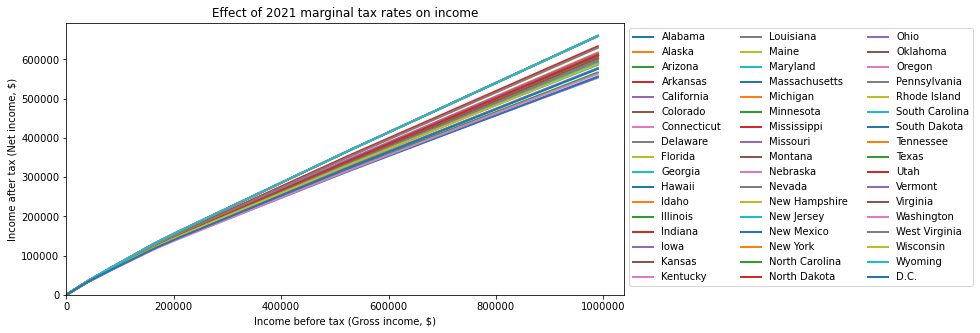

In [9]:
# graph all U.S. states for comparison
places = tax_df['Place'].unique()[13:].tolist()
plt.figure(figsize = (10,5))
for place in places:
    sns.lineplot(x = 'Income before tax', y = 'Income after tax', data = tax_df.loc[tax_df['Place'] == place], 
                 label = place, linewidth = 2)

plt.title('Effect of 2021 marginal tax rates on income')
plt.xlabel('Income before tax (Gross income, $)')
plt.ylabel('Income after tax (Net income, $)')
plt.legend(bbox_to_anchor=(1, 1), loc=2, ncol = 3)
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0.0)
plt.ylim(0.0);

TypeError: cannot unpack non-iterable AxesSubplot object

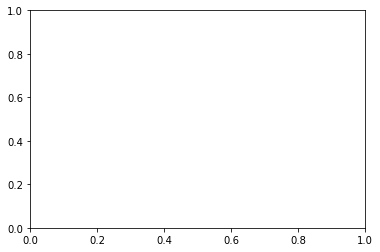

In [10]:
# plotting too many lines makes it very busy. Try a bar plot with a certain income instead.
places = tax_df['Place'].unique()[:13].tolist() # all provinces
# places = tax_df['Place'].unique()[13:].tolist() # all states

# Add a new column 'Tax paid' to tax_df
tax_df['Income tax paid'] = tax_df['Income before tax'] - tax_df['Income after tax']
tax_df = tax_df[['Place', 'Income before tax', 'Income tax paid', 'Income after tax']]

# make subset dataframes of particular incomes
tax50 = tax_df.loc[tax_df['Income before tax'] == 50000].sort_values(by=['Income tax paid'])
tax100 = tax_df.loc[tax_df['Income before tax'] == 100000].sort_values(by=['Income tax paid'])
tax150 = tax_df.loc[tax_df['Income before tax'] == 150000].sort_values(by=['Income tax paid'])
tax200 = tax_df.loc[tax_df['Income before tax'] == 200000].sort_values(by=['Income tax paid'])

# filter these dataframes by places of interest
tax50 = tax50.loc[tax50.Place.isin(places)]
tax100 = tax100.loc[tax100.Place.isin(places)]
tax150 = tax150.loc[tax150.Place.isin(places)]
tax200 = tax200.loc[tax200.Place.isin(places)]

fig,ax = plt.subplot()

plt.figure(figsize = (4,5))
sns.barplot(data = tax50, x = 'Income tax paid', y = 'Place')
sns.barplot(data = tax100, x = 'Income tax paid', y = 'Place')
sns.barplot(data = tax150, x = 'Income tax paid', y = 'Place')
sns.barplot(data = tax200, x = 'Income tax paid', y = 'Place');